In [90]:
import geopandas as gpd
import pandas as pd
# Ruta al shapefile (sin la extensión .shp si quieres)
ruta = r"G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - AVANCE COSECHA\2025\PLANOS RENOVACION\SHP\LOTES_CAÑA_2025.shp"
ruta_output = r"G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - AVANCE COSECHA\2025\PLANOS RENOVACION\SHP\LOTES_CAÑA_2025_RENOV.shp"

<Axes: >

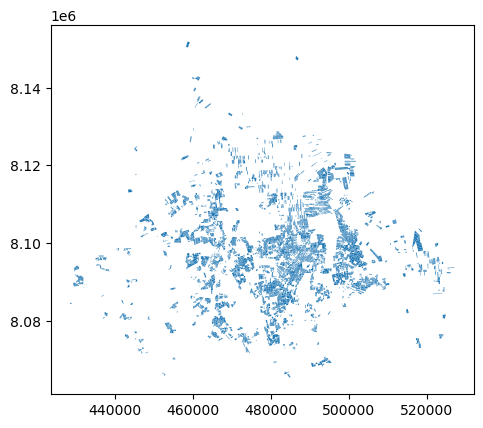

In [76]:
gdf = gpd.read_file(ruta)
gdf.plot()

In [77]:
gdf.columns

Index(['key', 'idd', 'fid_1', 'id', 'unidad_01', 'unidad_02', 'unidad_03',
       'unidad_04', 'unidad_05', 'variedad', 'soca', 'zona', 'textura',
       'cultivo', 'zafra', 'financia', 'fs', 'fc', 'area', 'estado', 'fci',
       'tipoc', 'codco', 'delegado', 'semana', 'est_gral', 'est_par', 'area_t',
       'cub', 'dias', 'iddd', 'tch', 'iddd_1', 'geometry'],
      dtype='object')

In [78]:
lista_cos_props = list(set(gdf['unidad_01']))
lista_cos_props = [int(i) for i in lista_cos_props]
print(lista_cos_props)

[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 57, 61, 62, 63, 66, 67, 68, 71, 72, 74, 76, 78, 79, 80, 83, 84, 85, 89, 92, 93, 94, 98, 100, 104, 105, 106, 108, 110, 111, 112, 113, 114, 116, 117, 118, 119, 122, 123, 124, 125, 126, 127, 129, 132, 133, 135, 136, 137, 139, 140, 141, 142, 145, 147, 149, 150, 155, 159, 161, 162, 164, 168, 171, 172, 173, 174, 176, 178, 179, 182, 183, 184, 185, 186, 187, 188, 189, 195, 197, 198, 201, 205, 206, 209, 211, 212, 213, 216, 217, 218, 219, 220, 221, 222, 225, 226, 227, 228, 229, 230, 231, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 244, 246, 247, 249, 250, 251, 253, 256, 257, 258, 259, 260, 261, 263, 264, 265, 267, 268, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 313,

In [86]:
import pandas as pd
import geopandas as gpd

catastro_renovacion = None

for cod in lista_cos_props:
    prop = gdf.loc[gdf['unidad_01'] == cod, ['unidad_01','unidad_02','unidad_03','unidad_04','unidad_05','area','tch','geometry']].copy()
    if prop.empty:
        continue

    prop['renovar'] = 0
    prop = prop.sort_values(by="tch", ascending=True).reset_index(drop=True)

    area_total = prop['area'].sum()
    area_20_porcen = area_total * 0.2
    area_acumulado = 0.0

    renovar_rows = []
    no_renovar_rows = []

    for _, row in prop.iterrows():
        if area_acumulado > area_20_porcen:
            no_renovar_rows.append(row)
        else:
            area_acumulado += float(row['area'])
            renovar_rows.append(row)

    # ---- helpers para construir GDFs aun si la lista está vacía ----
    def build_gdf(rows, template_gdf):
        if len(rows) > 0:
            df = pd.DataFrame(rows)
            return gpd.GeoDataFrame(df, geometry='geometry', crs=template_gdf.crs)
        else:
            # GeoDataFrame vacío con MISMAS columnas (incluye 'geometry')
            empty_df = pd.DataFrame(columns=list(template_gdf.columns))
            return gpd.GeoDataFrame(empty_df, geometry='geometry', crs=template_gdf.crs)

    gdf_renovar = build_gdf(renovar_rows, prop)
    if not gdf_renovar.empty:
        gdf_renovar.loc[:, 'renovar'] = 1

    gdf_no_renovar = build_gdf(no_renovar_rows, prop)
    if not gdf_no_renovar.empty:
        gdf_no_renovar.loc[:, 'renovar'] = 0

    gdf_union = pd.concat([gdf_renovar, gdf_no_renovar], ignore_index=True)
    gdf_union = gpd.GeoDataFrame(gdf_union, geometry='geometry', crs=prop.crs)

    if catastro_renovacion is None:
        catastro_renovacion = gdf_union
    else:
        catastro_renovacion = pd.concat([catastro_renovacion, gdf_union], ignore_index=True)
        catastro_renovacion = gpd.GeoDataFrame(catastro_renovacion, geometry='geometry', crs=prop.crs)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_57152\3396424908.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gdf_union = pd.concat([gdf_renovar, gdf_no_renovar], ignore_index=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_57152\3396424908.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gdf_union = pd.concat([gdf_renovar, gdf_no_renovar], ignore_index=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_57152\3396424908.py:46: FutureWarning: The behavior of DataFrame concatenation

In [88]:
catastro_renovacion['area'].sum()

55401.22

In [89]:
gdf['area'].sum()

55401.22

In [91]:
catastro_renovacion.to_file(ruta_output)

In [80]:
catastro_renovacion

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,tch,geometry,renovar
0,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L6.2.2,1.67,33.419162,"POLYGON ((490326.601 8088821.328, 490318.157 8...",1
1,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L13.2,7.26,43.384298,"POLYGON ((491592.370 8088549.135, 491606.418 8...",1
2,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L13.3,1.78,46.522472,"POLYGON ((491611.117 8088215.623, 491628.935 8...",1
3,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L2,7.29,50.423868,"POLYGON ((490824.385 8089170.262, 490841.344 8...",1
4,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L6.1,2.04,56.446078,"POLYGON ((490255.038 8089020.214, 490255.038 8...",1
5,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L7,4.37,57.881007,"POLYGON ((491162.246 8089061.556, 491398.757 8...",1
6,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L10.2,7.96,61.228643,"POLYGON ((490880.723 8088088.400, 490892.293 8...",0
7,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L9.1,3.87,61.511628,"POLYGON ((490966.961 8088249.090, 491213.175 8...",0
8,1.0,SONIMA,18358.0,ROJAS AMELUNGE CARLOS,L8.3,2.00,63.385000,"POLYGON ((490854.388 8088765.433, 490900.545 8...",0
9,1.0,SONIMA,18358.0,ROJAS AMELUNGE CARLOS,L8.2,9.43,64.672322,"POLYGON ((490288.917 8088729.239, 490291.926 8...",0


In [36]:
prop = gdf[gdf['unidad_01'] == 1]

In [37]:
prop.columns

Index(['key', 'idd', 'fid_1', 'id', 'unidad_01', 'unidad_02', 'unidad_03',
       'unidad_04', 'unidad_05', 'variedad', 'soca', 'zona', 'textura',
       'cultivo', 'zafra', 'financia', 'fs', 'fc', 'area', 'estado', 'fci',
       'tipoc', 'codco', 'delegado', 'semana', 'est_gral', 'est_par', 'area_t',
       'cub', 'dias', 'iddd', 'tch', 'iddd_1', 'geometry'],
      dtype='object')

In [50]:
prop = prop[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'tch', 'geometry' ]]
prop['renovar'] = 0
prop

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,tch,geometry,renovar
0,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L6.2.2,1.67,33.419162,"POLYGON ((490326.601 8088821.328, 490318.157 8...",0
1,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L13.2,7.26,43.384298,"POLYGON ((491592.370 8088549.135, 491606.418 8...",0
2,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L13.3,1.78,46.522472,"POLYGON ((491611.117 8088215.623, 491628.935 8...",0
3,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L2,7.29,50.423868,"POLYGON ((490824.385 8089170.262, 490841.344 8...",0
4,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L6.1,2.04,56.446078,"POLYGON ((490255.038 8089020.214, 490255.038 8...",0
5,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L7,4.37,57.881007,"POLYGON ((491162.246 8089061.556, 491398.757 8...",0
6,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L10.2,7.96,61.228643,"POLYGON ((490880.723 8088088.400, 490892.293 8...",0
7,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L9.1,3.87,61.511628,"POLYGON ((490966.961 8088249.090, 491213.175 8...",0
8,1.0,SONIMA,18358.0,ROJAS AMELUNGE CARLOS,L8.3,2.00,63.385000,"POLYGON ((490854.388 8088765.433, 490900.545 8...",0
9,1.0,SONIMA,18358.0,ROJAS AMELUNGE CARLOS,L8.2,9.43,64.672322,"POLYGON ((490288.917 8088729.239, 490291.926 8...",0


In [51]:
prop = prop.sort_values(by="tch", ascending=True).reset_index(drop=True)

In [52]:
area_total = prop['area'].sum()
area_20_porcen = area_total * 0.2

In [68]:
area_acumulado = 0
renovar_rows = []
no_renovar_rows = []

for index, row in prop.iterrows():
    if area_acumulado > area_20_porcen:
        # agregar a NO renovar
        no_renovar_rows.append(row)
    else:
        # sumar y agregar a RENOVAR
        area_acumulado += row["area"]
        renovar_rows.append(row)

# Convertimos listas → GeoDataFrames
gdf_renovar = gpd.GeoDataFrame(renovar_rows, geometry="geometry", crs=prop.crs)
gdf_renovar['renovar'] = 1
gdf_no_renovar = gpd.GeoDataFrame(no_renovar_rows, geometry="geometry", crs=prop.crs)
gdf_no_renovar['renovar'] = 0

gdf_union = pd.concat([gdf_renovar, gdf_no_renovar], ignore_index=True)
gdf_union = gpd.GeoDataFrame(gdf_union, geometry="geometry", crs=prop.crs)

<Axes: >

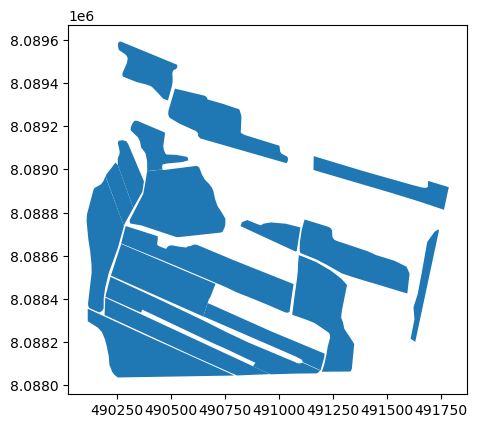

In [69]:
gdf_union.plot()

In [70]:
gdf_union

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,tch,geometry,renovar
0,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L6.2.2,1.67,33.419162,"POLYGON ((490326.601 8088821.328, 490318.157 8...",1
1,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L13.2,7.26,43.384298,"POLYGON ((491592.370 8088549.135, 491606.418 8...",1
2,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L13.3,1.78,46.522472,"POLYGON ((491611.117 8088215.623, 491628.935 8...",1
3,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L2,7.29,50.423868,"POLYGON ((490824.385 8089170.262, 490841.344 8...",1
4,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L6.1,2.04,56.446078,"POLYGON ((490255.038 8089020.214, 490255.038 8...",1
5,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L7,4.37,57.881007,"POLYGON ((491162.246 8089061.556, 491398.757 8...",1
6,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L10.2,7.96,61.228643,"POLYGON ((490880.723 8088088.400, 490892.293 8...",0
7,1.0,SONIMA,388.0,AGROPECUARIA MARIANA S.R.L.,L9.1,3.87,61.511628,"POLYGON ((490966.961 8088249.090, 491213.175 8...",0
8,1.0,SONIMA,18358.0,ROJAS AMELUNGE CARLOS,L8.3,2.00,63.385000,"POLYGON ((490854.388 8088765.433, 490900.545 8...",0
9,1.0,SONIMA,18358.0,ROJAS AMELUNGE CARLOS,L8.2,9.43,64.672322,"POLYGON ((490288.917 8088729.239, 490291.926 8...",0
